# Paired integration and query-to-reference mapping

In this tutorial, we demonstrate how to use MultiMIL's integration module for paired integration, i.e. reference building, and mapping on the query onto the built reference. We will use NeurIPS 2021 CITE-seq dataset {cite:p}`Luecken2021-ct`.

In [1]:
import sys

# if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install multimil
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/multimil

In [2]:
import anndata as ad
import multimil as mtm
import muon
import scanpy as sc
import warnings

warnings.filterwarnings("ignore")

[rank: 0] Global seed set to 0


## Data loading

The data contains 90,261 bone marrow mononuclear cells. This CITE-seq (i.e. paired gene expression and surface protein adundance) dataset was generated at 4 different sites introducing some batch effect. After the quality control performed by the authors, the data contains measurements from 13,953 genes and 134 proteins.

In [3]:
data_path = "/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/trimodal/data/raw/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad"

In [4]:
try:
    adata = sc.read_h5ad(data_path)
except OSError:
    !wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
    !gzip -d GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
    adata = sc.read_h5ad(data_path)

adata

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Data preparation

We subsample the data to speed up the training.

In [5]:
sc.pp.subsample(adata, n_obs=20000)
adata

AnnData object with n_obs × n_vars = 20000 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We split the data into the gene counts and protein counts. 

In [6]:
rna = adata[:, adata.var["feature_types"] == "GEX"].copy()
rna

AnnData object with n_obs × n_vars = 20000 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [7]:
adt = adata[:, adata.var["feature_types"] == "ADT"].copy()
adt

AnnData object with n_obs × n_vars = 20000 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [8]:
# to free memory
del adata

## RNA preprocessing

Next, we log-normalize the raw counts and subset the RNA data to 2,000 highly variable genes.

In [9]:
rna.X = rna.layers["counts"].copy()

In [10]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [11]:
n_top_genes = 2000
batch_key = "Site"

In [12]:
sc.pp.highly_variable_genes(rna, n_top_genes=n_top_genes, batch_key=batch_key, subset=True)
rna

AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## ADT preprocessing

We will use centered log-ratio (CLR) noralization for the ADT modality.

In [13]:
adt.X = adt.layers["counts"].copy()

In [14]:
muon.prot.pp.clr(adt)
adt.layers["clr"] = adt.X.copy()

## Data setup

Next, we create one `AnnData` object from the RNA and ADT objects and specify which layers to use during training.

In [15]:
adata = mtm.data.organize_multimodal_anndatas(
    adatas=[[rna], [adt]],  # a list of anndata objects per modality, RNA-seq always goes first
    layers=[["counts"], ["clr"]],  # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 20000 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

The data comes from 4 different sites, so we select one of the sites as the query.

In [16]:
query = adata[adata.obs[batch_key] == "site1"].copy()
adata = adata[adata.obs[batch_key] != "site1"].copy()
(adata, query)

(AnnData object with n_obs × n_vars = 16433 × 2134
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
     var: 'modality'
     uns: 'modality_lengths'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3567 × 2134
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorS

We specify which covariates we want to integrate out during training, i.e. if there is batch effect in the data we want to correct, which covariate should be used as the batch covariate. Please refer to the API if you need to specify multiple covariates or continuous covariates.

In [17]:
rna_indices_end = rna.shape[1]

In [18]:
mtm.model.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=[batch_key],
    rna_indices_end=rna_indices_end,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Model setup and training

In the next step, we initialize the model. We need to pass which `adata` the model will be trained on and which losses should be used for each of the modalities. Since we use raw counts for RNA, we will use negative binomial loss here (`'nb'`), and MSE (`'mse'`) for the normalized ADT counts.

In [19]:
vae = mtm.model.MultiVAE(
    adata,
    losses=["nb", "mse"],
)

Now, we finally are set and can train the model and visualize the losses.

In [20]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [03:08<00:00,  1.15it/s, loss=617, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:08<00:00,  1.06it/s, loss=617, v_num=1]


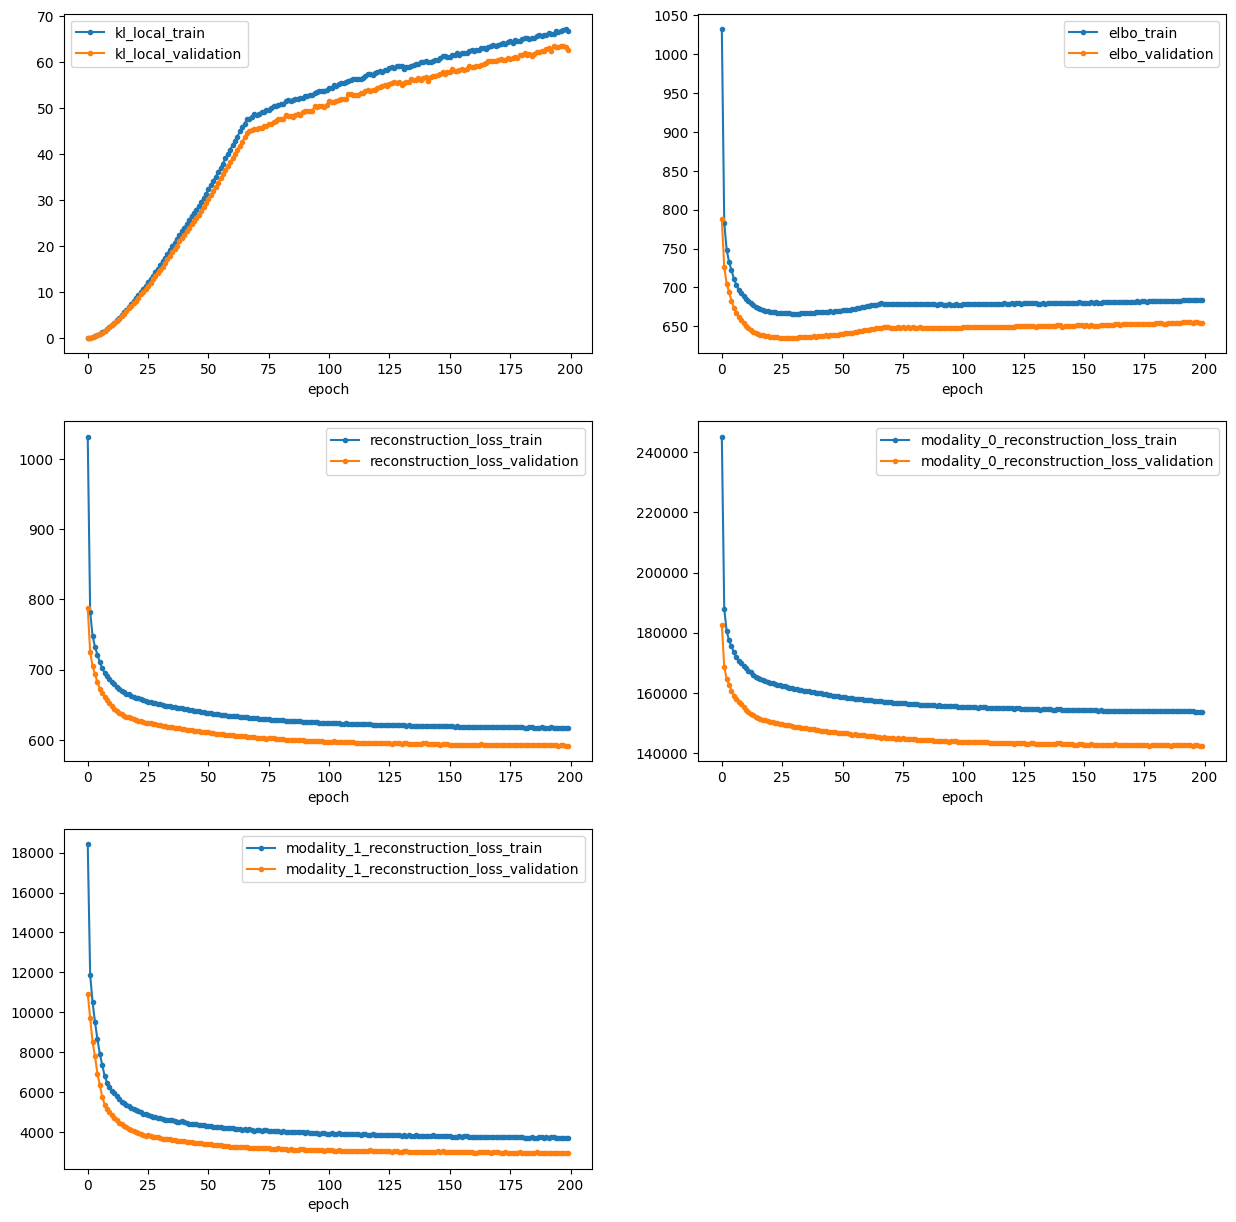

In [21]:
vae.plot_losses()

## Visualizing the latent space

Next, we retrieve the learned latent representation; it is automatically saved in `adata.obsm['X_multiMIL']`.

In [22]:
vae.get_model_output()
adata

AnnData object with n_obs × n_vars = 16433 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

Finally, we visualize the latent space.

In [23]:
sc.pp.neighbors(adata, use_rep="X_multiMIL")
sc.tl.umap(adata)

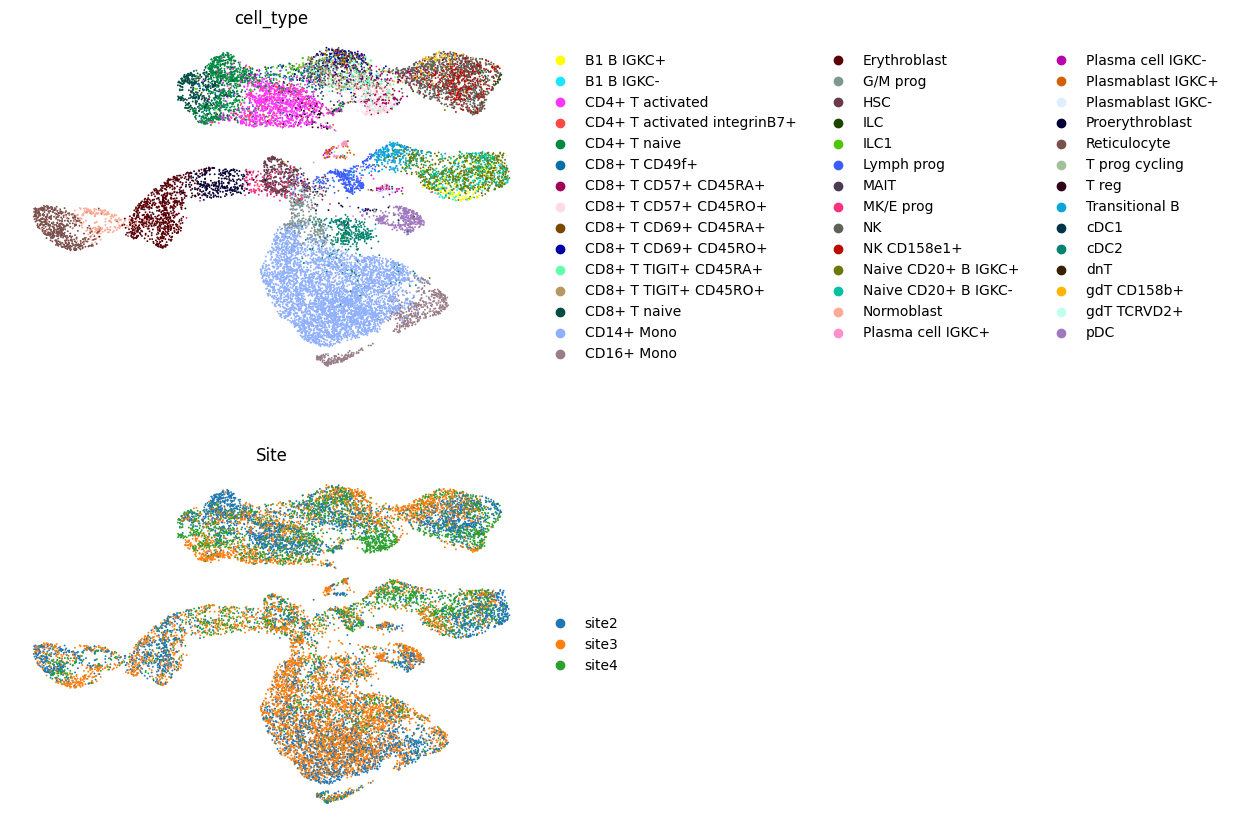

In [24]:
sc.pl.umap(adata, color=["cell_type", "Site"], frameon=False, ncols=1)

## Preparing the query

MultiMIL is equipped with scArches approach {cite:p}`Lotfollahi2022-jw` to map new query data onto existing references.

First, we need to update the model architecture to add weights for the new query batches.

In [25]:
new_vae = mtm.model.MultiVAE.load_query_data(query, reference_model=vae)

Next, we fine-tune the newly added weights to optimize the reconstruction of the query data. We set `weight_decay` to zero to make sure that the rest of the weights in the model will not be changed.

In [26]:
new_vae.train(
    weight_decay=0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  5.03it/s, loss=822, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  4.88it/s, loss=822, v_num=1]


Now, we obtain the latent representation of the query and visualize both the reference and the query together.

In [27]:
new_vae.get_model_output(query)
query

AnnData object with n_obs × n_vars = 3567 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

In [28]:
adata.obs["reference"] = "reference"
query.obs["reference"] = "query"
adata_both = ad.concat([adata, query])
adata_both

AnnData object with n_obs × n_vars = 20000 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch', 'reference'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL'
    layers: 'counts'

In [29]:
sc.pp.neighbors(adata_both, use_rep="X_multiMIL")
sc.tl.umap(adata_both)

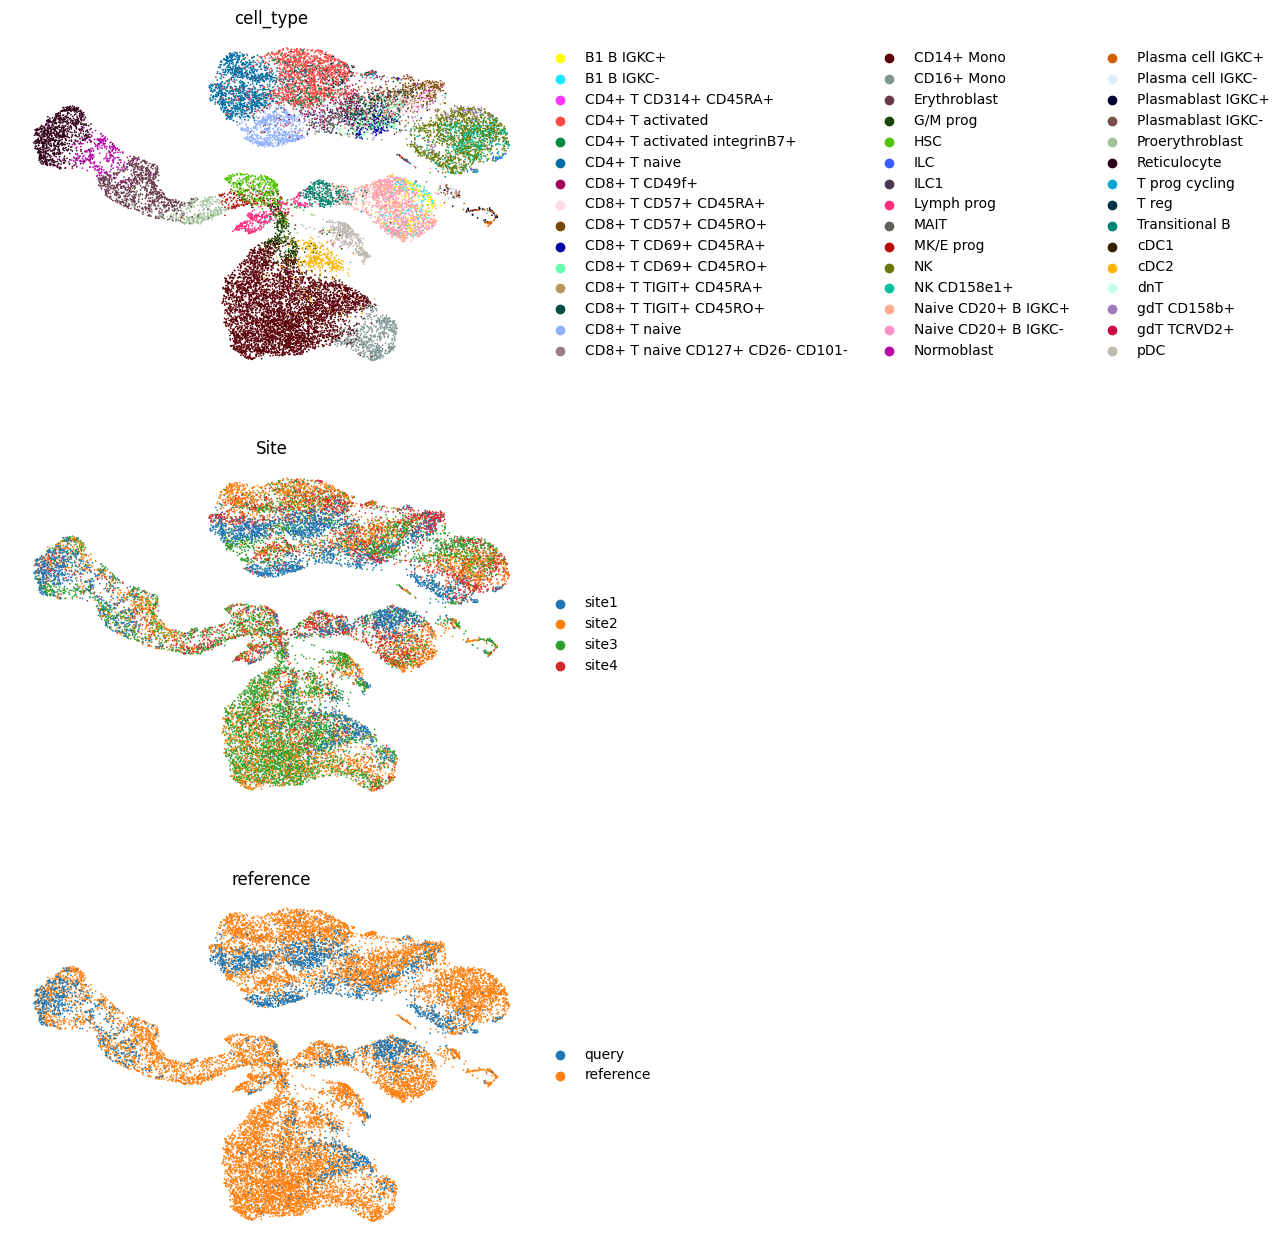

In [30]:
sc.pl.umap(adata_both, color=["cell_type", "Site", "reference"], ncols=1, frameon=False)